In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [2]:
#Carico il dataset

data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

data = data.sample(frac=1, random_state=45).reset_index(drop=True) #shuffle

print("Shape del dataset : ", data.shape)


Shape del dataset :  (13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


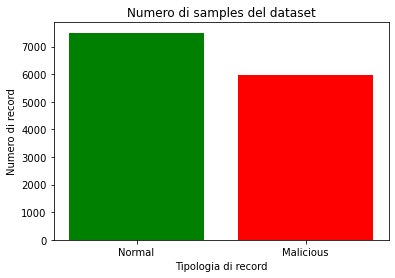

In [3]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

R2L :  381      Normal :  7500
U2R :  50       DOS :  5000
Probe :  520


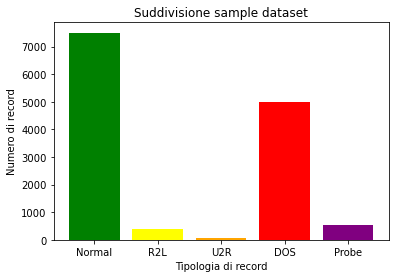

In [4]:
#plot che mi mostra la suddivisione tra i 4 attacchi

r2l_flows_count = len(data[data.result == "r2l"])
u2r_flows_count = len(data[data.result == "u2r"])
dos_flows_count = len(data[data.result == "dos"])
probe_flows_count = len(data[data.result == "probe"])

print("R2L : ",r2l_flows_count,"     Normal : ",normal_flows_count)
print("U2R : ",u2r_flows_count,"      DOS : ",dos_flows_count)
print("Probe : ",probe_flows_count)

left = [1, 1.5, 2, 2.5, 3] 
  
# heights of bars 
height = [normal_flows_count, r2l_flows_count, u2r_flows_count, dos_flows_count, probe_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'R2L', "U2R", "DOS", "Probe"] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green','yellow', 'orange', 'red', 'purple']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Suddivisione sample dataset') 
  
plt.show() 

In [5]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [6]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
data.flag.replace(flag_list, range(len(flag_list)), inplace=True)

encode_numeric_zscore(data, 'duration')
encode_numeric_zscore(data, 'src_bytes')
encode_numeric_zscore(data, 'dst_bytes')
encode_numeric_zscore(data, 'land')
encode_numeric_zscore(data, 'land')
encode_numeric_zscore(data, 'wrong_fragment')
encode_numeric_zscore(data, 'urgent')
encode_numeric_zscore(data, 'hot')
encode_numeric_zscore(data, 'num_failed_logins')
encode_numeric_zscore(data, 'logged_in')
encode_numeric_zscore(data, 'num_compromised')
encode_numeric_zscore(data, 'root_shell')
encode_numeric_zscore(data, 'su_attempted')
encode_numeric_zscore(data, 'num_root')
encode_numeric_zscore(data, 'num_file_creations')
encode_numeric_zscore(data, 'num_shells')
encode_numeric_zscore(data, 'num_access_files')
encode_numeric_zscore(data, 'is_guest_login')
encode_numeric_zscore(data, 'count')

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [7]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Conversione feature "count" in linguaggio macchina . . .')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Conversione indici 1,2,3 in linguaggio macchina . . .')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Rimuovo le features di indici 1,2,3 e concateno un hot encoder array')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print("")
print("")
print('Final shape of data:', data_final.shape)
print("")
print("")

Conversione feature "count" in linguaggio macchina . . .
Conversione indici 1,2,3 in linguaggio macchina . . .
Rimuovo le features di indici 1,2,3 e concateno un hot encoder array


Final shape of data: (13451, 95)




Epoch 1/15
71/71 [==============================] - 17s 244ms/step - loss: 0.1375 - val_loss: 0.2215
Epoch 2/15
71/71 [==============================] - 21s 292ms/step - loss: 0.0994 - val_loss: 0.1756
Epoch 3/15
71/71 [==============================] - 21s 295ms/step - loss: 0.0728 - val_loss: 0.1734
Epoch 4/15
71/71 [==============================] - 20s 289ms/step - loss: 0.0717 - val_loss: 0.1721
Epoch 5/15
71/71 [==============================] - 21s 292ms/step - loss: 0.0707 - val_loss: 0.1709
Epoch 6/15
71/71 [==============================] - 22s 306ms/step - loss: 0.0702 - val_loss: 0.1709
Epoch 7/15
71/71 [==============================] - 22s 304ms/step - loss: 0.0698 - val_loss: 0.1705
Epoch 8/15
71/71 [==============================] - 21s 301ms/step - loss: 0.0698 - val_loss: 0.1705
Epoch 9/15
71/71 [==============================] - 22s 304ms/step - loss: 0.0697 - val_loss: 0.1694
Epoch 10/15
71/71 [==============================] - 21s 290ms/step - loss: 0.0696 - val_lo

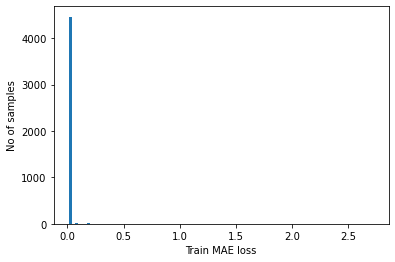

Reconstruction error threshold:  0.016414227


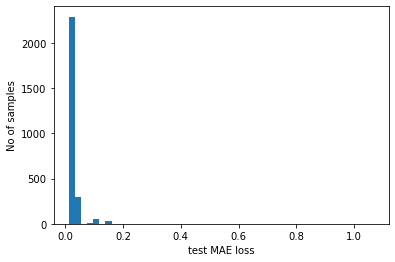

Number di sample anomali rilevati:  1517
Numero di sample anomali rivelati erroneamente:  343 (FN)
Numero di sample anomali rilevati correttamente:  1174 (TN)
Numero di sample anomali non rivelati:  16 (FP)
Numero di sample normali rivelati correttamente 1157 (TP)

Numero di sample anomali U2R rilevati correttamente:  8 (TN)
Numero di sample anomali U2R considerati Normali : 4 (FP)
Numero di sample anomali R2L rilevati correttamente:  57 (TN)
Numero di sample anomali R2L considerati normali : 12 (FP)
Numero di sample anomali Probe rilevati correttamente:  93 (TN)
Numero di sample anomali Probe considerati normali : 0 (FP)
Numero di sample anomali Dos rilevati correttamente:  1016 (TN)
Numero di sample anomali Dos considerati normali : 0 (FP)

### 0 Anomaly / 1 Normal ###


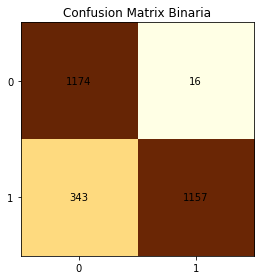

          predicted labels  
0 :
             precision:  0.774
             recall:     0.987


1 :
             precision:  0.986
             recall:     0.771


Avg precision:     0.880
Avg weight precision:     0.892
Avg recall:     0.879
Avg weight recall:     0.867

Accuracy:  0.86654
Epoch 1/15
71/71 [==============================] - 20s 275ms/step - loss: 0.0914 - val_loss: 0.1724
Epoch 2/15
71/71 [==============================] - 19s 274ms/step - loss: 0.0710 - val_loss: 0.1713
Epoch 3/15
71/71 [==============================] - 20s 283ms/step - loss: 0.0705 - val_loss: 0.1711
Epoch 4/15
71/71 [==============================] - 21s 290ms/step - loss: 0.0701 - val_loss: 0.1702
Epoch 5/15
71/71 [==============================] - 20s 275ms/step - loss: 0.0699 - val_loss: 0.1699
Epoch 6/15
71/71 [==============================] - 20s 282ms/step - loss: 0.0697 - val_loss: 0.1694
Epoch 7/15
71/71 [==============================] - 20s 282ms/step - loss: 0.0696 - val_loss: 0.1688


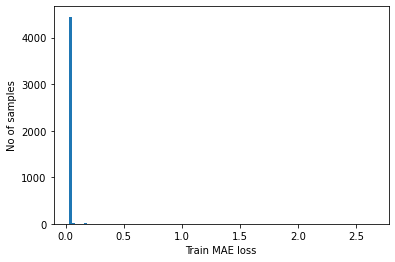

Reconstruction error threshold:  0.033848964


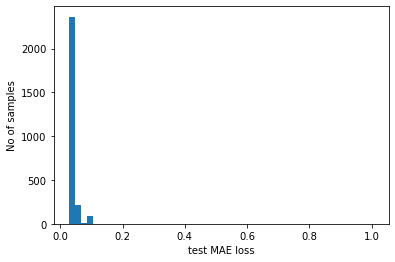

Number di sample anomali rilevati:  1518
Numero di sample anomali rivelati erroneamente:  346 (FN)
Numero di sample anomali rilevati correttamente:  1172 (TN)
Numero di sample anomali non rivelati:  18 (FP)
Numero di sample normali rivelati correttamente 1154 (TP)

Numero di sample anomali U2R rilevati correttamente:  8 (TN)
Numero di sample anomali U2R considerati Normali : 4 (FP)
Numero di sample anomali R2L rilevati correttamente:  58 (TN)
Numero di sample anomali R2L considerati normali : 11 (FP)
Numero di sample anomali Probe rilevati correttamente:  92 (TN)
Numero di sample anomali Probe considerati normali : 1 (FP)
Numero di sample anomali Dos rilevati correttamente:  1014 (TN)
Numero di sample anomali Dos considerati normali : 2 (FP)

### 0 Anomaly / 1 Normal ###


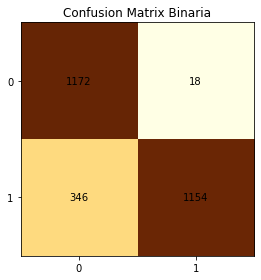

          predicted labels  
0 :
             precision:  0.772
             recall:     0.985


1 :
             precision:  0.985
             recall:     0.769


Avg precision:     0.878
Avg weight precision:     0.891
Avg recall:     0.877
Avg weight recall:     0.865

Accuracy:  0.86468
Epoch 1/15
71/71 [==============================] - 21s 292ms/step - loss: 0.1076 - val_loss: 0.1750
Epoch 2/15
71/71 [==============================] - 20s 287ms/step - loss: 0.0729 - val_loss: 0.1725
Epoch 3/15
71/71 [==============================] - 20s 278ms/step - loss: 0.0716 - val_loss: 0.1730
Epoch 4/15
71/71 [==============================] - 21s 289ms/step - loss: 0.0711 - val_loss: 0.1712
Epoch 5/15
71/71 [==============================] - 20s 277ms/step - loss: 0.0704 - val_loss: 0.1711
Epoch 6/15
71/71 [==============================] - 20s 285ms/step - loss: 0.0705 - val_loss: 0.1708
Epoch 7/15
71/71 [==============================] - 20s 287ms/step - loss: 0.0703 - val_loss: 0.1716


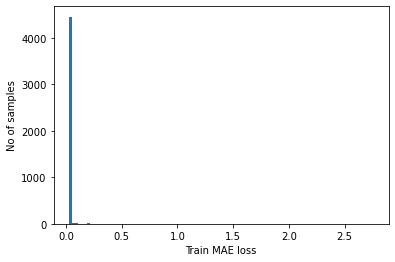

Reconstruction error threshold:  0.03043169


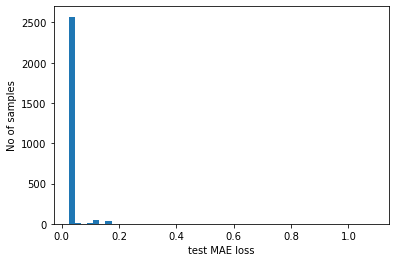

Number di sample anomali rilevati:  1530
Numero di sample anomali rivelati erroneamente:  354 (FN)
Numero di sample anomali rilevati correttamente:  1176 (TN)
Numero di sample anomali non rivelati:  14 (FP)
Numero di sample normali rivelati correttamente 1146 (TP)

Numero di sample anomali U2R rilevati correttamente:  8 (TN)
Numero di sample anomali U2R considerati Normali : 4 (FP)
Numero di sample anomali R2L rilevati correttamente:  63 (TN)
Numero di sample anomali R2L considerati normali : 6 (FP)
Numero di sample anomali Probe rilevati correttamente:  91 (TN)
Numero di sample anomali Probe considerati normali : 2 (FP)
Numero di sample anomali Dos rilevati correttamente:  1014 (TN)
Numero di sample anomali Dos considerati normali : 2 (FP)

### 0 Anomaly / 1 Normal ###


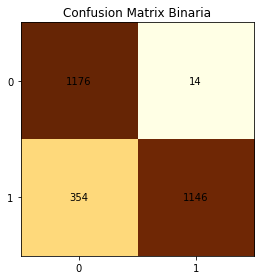

          predicted labels  
0 :
             precision:  0.769
             recall:     0.988


1 :
             precision:  0.988
             recall:     0.764


Avg precision:     0.878
Avg weight precision:     0.891
Avg recall:     0.876
Avg weight recall:     0.863

Accuracy:  0.86320
Epoch 1/15
71/71 [==============================] - 20s 279ms/step - loss: 0.1018 - val_loss: 0.1717
Epoch 2/15
71/71 [==============================] - 20s 277ms/step - loss: 0.0709 - val_loss: 0.1686
Epoch 3/15
71/71 [==============================] - 20s 276ms/step - loss: 0.0698 - val_loss: 0.1678
Epoch 4/15
71/71 [==============================] - 20s 278ms/step - loss: 0.0691 - val_loss: 0.1617
Epoch 5/15
71/71 [==============================] - 20s 282ms/step - loss: 0.0674 - val_loss: 0.1560
Epoch 6/15
60/71 [========================>.....] - ETA: 3s - loss: 0.0742

KeyboardInterrupt: 

In [8]:
normal_data = data_final[data_final[94] == "normal"] #prendo solo i valori "normali" 

#voglio che sia il train che la validation siano effettuati su record normali ma che siano tra loro differenti
for i in range(10):
    data_train, data_val, data_test = np.split(normal_data, [int(.6*len(normal_data)), int(.8*len(normal_data))])
        
    x_train = data_train.drop([94],axis=1) #rimuove la colonna result dal dataframe
    x_val = data_val.drop([94], axis=1) #rimuove il label

    x_train_arr = np.asarray(x_train).astype(np.float32)
    x_train_arr = x_train_arr.reshape(x_train_arr.shape[0],x_train_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

    x_val_arr = np.asarray(x_val).astype(np.float32)
    x_val_arr = x_val_arr.reshape(x_val_arr.shape[0],x_val_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
    
    model = keras.Sequential(
    [
       layers.Input(shape=(x_train_arr.shape[1],x_train_arr.shape[2])),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(64),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(x_train_arr.shape[1], activation='sigmoid'),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.TimeDistributed(layers.Dense(1)),
    ]
    )

    model.compile( optimizer='adam', loss='mse')
    
    history = model.fit(
    x_train_arr,
    x_train_arr,
    epochs=15,
    batch_size=64,
    validation_data=(x_val_arr, x_val_arr),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
    )
    
    x_train_pred = model.predict(x_train_arr)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train_arr), axis=1)
    train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
    train_mae_loss = np.sort(train_mae_loss) #quicksort


    train_mae_loss_len = len(train_mae_loss)
    n_index = int(0.75*train_mae_loss_len)
    plt.hist(train_mae_loss, bins=100)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    train_mae_loss_split = train_mae_loss[:n_index]
    threshold = np.max(train_mae_loss_split)
    print("Reconstruction error threshold: ", threshold)
    
    #data_test
    #il dataset per il test sarà formato dai 1500 sample normali prelevati precedentemente a cui aggiungerò dei sample anomali
    #in particolare prelevo il 20% dei sample anomali e li concateno ai 1500 normali precedentemente ottenuti

    anomaly_data = data_final[data_final[94] != "normal"] #prendo solo i valori "anomali"

    percentage = 20
    anomaly_test_data = anomaly_data.head(int(len(anomaly_data)*(percentage/100)))

    frames = [data_test, anomaly_test_data]
    final_test_data = pd.concat(frames)

    data_test_with_label = final_test_data.copy()
    x_test = final_test_data.drop([94],axis=1) #rimuove la colonna dei result dal dataframe

    x_test_arr = np.asarray(x_test).astype(np.float32)
    x_test_arr = x_test_arr.reshape(x_test_arr.shape[0],x_test_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

    arr_test_pred = model.predict(x_test_arr)
    test_mae_loss = np.mean(np.abs(arr_test_pred - x_test_arr), axis=1)
   

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()


    # Riconosce tutti i sample che sono anomalie
    anomalies = (test_mae_loss > threshold).tolist()


    count = 0
    false_negative = 0
    false_positive = 0
    u2r_rilevati = 0
    u2r_non_rilevati = 0
    r2l_rilevati = 0
    r2l_non_rilevati = 0
    probe_rilevati = 0
    probe_non_rilevati = 0
    dos_rilevati = 0
    dos_non_rilevati = 0
    true_positive = 0

    for i in anomalies:
        x = str(i)
        if ( x == '[True]'): #Sono le anomalie rilevate
            if ( data_test_with_label.iloc[count][94] == "normal"):
                false_negative = false_negative + 1 #Anomalie rilevate che in realtà erano record normali
            if ( data_test_with_label.iloc[count][94] == "u2r"):
                u2r_rilevati = u2r_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "r2l"):
                r2l_rilevati = r2l_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "probe"):
                probe_rilevati = probe_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "dos"):
                dos_rilevati = dos_rilevati + 1
        if (x == '[False]'):
            if( data_test_with_label.iloc[count][94] != "normal"):
                false_positive = false_positive + 1
            if ( data_test_with_label.iloc[count][94] == "u2r"):
                u2r_non_rilevati = u2r_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "r2l"):
                r2l_non_rilevati = r2l_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "probe"):
                probe_non_rilevati = probe_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "dos"):
                dos_non_rilevati = dos_non_rilevati + 1
            if ( data_test_with_label.iloc[count][94] == "normal"):
                true_positive = true_positive + 1
        count = count + 1
    
    true_negative = np.sum(anomalies)-false_negative
        
    print("Number di sample anomali rilevati: ", np.sum(anomalies))
    print("Numero di sample anomali rivelati erroneamente: ", false_negative,'(FN)')
    print("Numero di sample anomali rilevati correttamente: ", true_negative, '(TN)')
    print("Numero di sample anomali non rivelati: ", false_positive, '(FP)')
    print("Numero di sample normali rivelati correttamente", true_positive,"(TP)")
    print("")
    print("Numero di sample anomali U2R rilevati correttamente: ", u2r_rilevati, '(TN)')
    print("Numero di sample anomali U2R considerati Normali :", u2r_non_rilevati, '(FP)')
    print("Numero di sample anomali R2L rilevati correttamente: ", r2l_rilevati, '(TN)')
    print("Numero di sample anomali R2L considerati normali :", r2l_non_rilevati, '(FP)')
    print("Numero di sample anomali Probe rilevati correttamente: ", probe_rilevati, '(TN)')
    print("Numero di sample anomali Probe considerati normali :", probe_non_rilevati, '(FP)')
    print("Numero di sample anomali Dos rilevati correttamente: ", dos_rilevati, "(TN)")
    print("Numero di sample anomali Dos considerati normali :", dos_non_rilevati, "(FP)")
    print("")

    indici_riga_colonna = ['0','1']


    values = np.array([[true_negative, false_positive],
                       [false_negative, true_positive]])

    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap='YlOrBr')

    ax.set_xticks(np.arange(len(indici_riga_colonna)))
    ax.set_yticks(np.arange(len(indici_riga_colonna)))

    ax.set_xticklabels(indici_riga_colonna)
    ax.set_yticklabels(indici_riga_colonna)

    plt.setp(ax.get_xticklabels(),
             rotation_mode="anchor")

    for i in range(len(indici_riga_colonna)):
        for j in range(len(indici_riga_colonna)):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center")

    ax.set_title("Confusion Matrix Binaria")
    fig.tight_layout()

    print("### 0 Anomaly / 1 Normal ###")
    plt.show()

    print("          predicted labels  ")

    zero_precision = true_negative/(true_negative + false_negative) 
    one_precision = true_positive/(true_positive + false_positive) 

    zero_recall = true_negative/(true_negative + false_positive)
    one_recall = true_positive/(true_positive + false_negative)

    accuracy= (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    print("0 :")
    print("             precision: ","%.3f" % zero_precision)
    print("             recall: ","   %.3f" % zero_recall)
    print("")
    print("")
    print("1 :")
    print("             precision: ","%.3f" % one_precision)
    print("             recall: ","   %.3f" % one_recall)
    print("")
    print("")
    avg_precision = (zero_precision + one_precision)/2
    avg_precision_weight = (zero_precision*(true_negative+false_positive) + one_precision*(false_negative + true_positive))/(true_negative + false_positive + false_negative + true_positive)
    avg_recall = (zero_recall + one_recall)/2
    avg_recall_weight = (zero_recall*(true_negative+false_positive) + one_recall*(false_negative + true_positive))/(true_negative + false_positive + false_negative + true_positive)
    print("Avg precision: ","   %.3f" % avg_precision)
    print("Avg weight precision: ","   %.3f" % avg_precision_weight)
    print("Avg recall: ","   %.3f" % avg_recall)
    print("Avg weight recall: ","   %.3f" % avg_recall_weight)
    print("")
    print("Accuracy: ", "%.5f" % accuracy)